<h2 style="text-align:center;font-size:200%;">
    <b>Omics data analysis : exploration notebook</b>
</h2>
<h3  style="text-align:center;">Keywords : 
    <span style="border-radius:7px;background-color:yellowgreen;color:white;padding:7px;">OMICS</span>
    <span style="border-radius:7px;background-color:yellowgreen;color:white;padding:7px;">Transcriptomics</span>
    <span style="border-radius:7px;background-color:yellowgreen;color:white;padding:7px;">Differential Expression</span>
    <span style="border-radius:7px;background-color:yellowgreen;color:white;padding:7px;">Gene</span>
    <span style="border-radius:7px;background-color:yellowgreen;color:white;padding:7px;">Biology</span>
</h3>


This notebook serves as a comprehensive analytical pipeline for exploring and analyzing transcriptomics data, specifically focusing on differential gene expression analysis in disease contexts. Through a systematic workflow, it demonstrates the implementation of key bioinformatics techniques including data preprocessing, statistical analysis using DESeq2, and various visualization methods to uncover meaningful biological insights. 

This analytical framework is particularly valuable for pharmaceutical R&D teams seeking to understand disease mechanisms through transcriptomics data exploration.

This notebook encompasses 3 main activities:
1. The training of a model for differential expression analysis to identify significantly regulated genes between disease and control conditions
2. The visualization of the omics data through classical charts used in bioinformatics: volcano plots, principal component analysis (PCA), hierarchical clustering heatmaps ... to reveal expression patterns and sample relationships
3. Enrich this analysis with Gene Ontology (GO) to highlight the main biological processes and pathways affected in the disease state

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">1. Setup & Package Imports</div>

This notebook will used specific packages fully dedicated to bioinformatics and biological sciences. Among these packages we find : 
- pydeseq2: A Python implementation of the DESeq2 algorithm, originally developed in R. Two main components are createdwith this package : **DeseqDataSet** for data container and **DeseqStats** for statistical analysis. This package is useful for
    - Differential expression analysis in RNA-seq data
    - Handling count data and performing statistical testing
    - Normalizing data and estimating size factors
- scanpy: A Python package for single-cell genomics analysis that provides:
    - Efficient tools for dimensionality reduction (PCA used in this notebook)
    - Data preprocessing capabilities
    - Visualization tools for large-scale gene expression data
- sanbomics: A utility package providing:
    - Tools for mapping between different gene identifiers (id_map)
    - Specialized plotting functions for genomics data (volcano plots)
- Gene Ontology Analysis Tools (goatools): which is appropriate to download the genes ontology terms and definitions and to retrieves gene-to-GO mappings from NCBI. It uses NCBI's human protein-coding genes database (GENEID2NT)

In [136]:
# Generic packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pickle
import os

# Graphical packages 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Biocomputing packages
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sanbomics.tools import id_map
from sanbomics.plots import volcano
import scanpy as sc

# Genome Ontologies librairies
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">2. Data Loading & Preprocessing</div>

The data preprocessing pipeline begins with loading raw RNA-seq count data from a Kawasaki Disease study (GSE178491), followed by essential structuring steps including setting Ensembl gene IDs as index, removing zero-count genes, and organizing the data matrix with samples as rows and genes as columns. 

A crucial part of the preparation involves creating a metadata DataFrame that distinguishes between disease ('Kawa') and control ('Ctrl') samples, while ensuring all count data is converted to integers as required by the DESeq2 analysis framework.

In [137]:
# Disease selection adn associated dictionnaries
disease = 'kawasaki'

disease_dict = {
    'kawasaki':'../data/raw/GSE178491_KD.csv',
    'sars-cov2':'../data/raw/GSE151513.csv',
}

disease_condition = {
    'kawasaki':'KD',
    'sars-cov2':'INF',
}

disease_list_genes = {
    'kawasaki':['CCR5', 'USP18', 'KCTD14', 'MT-RNR1', 'CCL2', 'PROS1', 'IL1RL1', 'IL1R2', 'MAOB', 'KLF14'],
    'sars-cov2':[ 'MT-ND2', 'ANXA2', 'NDUFC2', 'CD63', 'SLIRP', 'OAZ1', 'MT-ND1', 'GNAS', 'MT-CO2', 'AKR1B1'],
}

In [138]:
# Load raw data
data = pd.read_csv(disease_dict[disease], sep=",")

# Preprocess data - Replace the index by the 'ensembl_gene_id'
data.set_index('ensembl_gene_id', inplace=True)
data.drop('genename', axis=1, inplace=True)
data = data[data.sum(axis=1) > 0].T

# Create metadata dataset to indicate which patients are healthy and which patients are sick
sample_list = data.index.tolist()
condition_list = ['Disease' if disease_condition[disease] in item else 'Ctrl' for item in sample_list]
metadata = pd.DataFrame({
    'Sample': sample_list, 
    'Condition': condition_list
}).set_index('Sample')

In [139]:
# Convert all count data to integers because differential expression analysis tool required integer values
# !! required by pyydeseq2 
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].astype(int)

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, KD1 to control30
Columns: 56518 entries, ENSG00000000003 to ENSG00000288111
dtypes: int32(56518)
memory usage: 29.1+ MB


In [141]:
data.sample(10)

ensembl_gene_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288102,ENSG00000288103,ENSG00000288104,ENSG00000288105,ENSG00000288106,ENSG00000288107,ENSG00000288108,ENSG00000288109,ENSG00000288110,ENSG00000288111
control17,42,0,333,861,465,2488,7,147,531,653,...,0,0,1,66,2,36,0,0,0,0
control27,54,0,225,932,464,6945,48,424,524,832,...,0,2,2,164,4,257,0,23,0,0
KD50,75,0,227,979,260,8325,14,309,381,1152,...,0,0,0,97,5,100,0,0,1,3
control18,34,0,843,866,484,2473,10,215,414,695,...,0,1,2,66,1,54,0,0,0,1
control30,101,0,167,758,208,5164,15,189,274,1281,...,0,1,1,112,1,67,0,0,0,4
KD75,57,0,554,1163,253,5411,20,370,427,1239,...,0,1,2,79,1,73,0,1,0,1
KD72,34,0,257,889,169,9413,12,237,392,850,...,0,3,0,69,2,48,0,0,0,1
control7,10,0,29,112,23,129,3,20,47,92,...,0,0,0,13,0,2,0,0,0,0
KD51,90,0,242,1133,309,6426,26,404,588,1199,...,0,0,0,116,0,91,0,0,0,3
KD30,71,0,480,1202,330,7445,15,442,518,1542,...,0,2,0,84,2,56,0,1,0,1


In [142]:
metadata.sample(5)

,Condition
Sample,
KD59,Disease
KD50,Disease
KD85,Disease
KD70,Disease
KD69,Disease


**Conclusion :**

After loading preprocessing, we get a dataframe of :
- 135 rows corresponding to a mix of disease patients (prefixed with "KD") and controls (prefixed with "control")
- 56 518 columns representing genes, identified by their "Ensembl IDs" which is the standard Ensembl gene identifier (from ENSG00000000003 to ENSG00000288111)

This matrix structure is ideal for differential expression analysis with DESeq2, where each cell represents the expression level of a specific gene in a given sample.

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">3. Differential Expression Analysis</div>

The DESeq2 analysis begins by creating a specialized data structure (DeseqDataSet) that combines the gene expression count matrix with sample metadata, where "Condition" (Kawa vs Ctrl) is specified as the experimental design factor for comparison. 

The statistical analysis is then performed through the deseq2() method, which **normalizes the data** and **estimates size factors**, followed by the **calculation of differential expression statistics** using DeseqStats, which compares the Kawasaki disease samples against control samples to identify significantly differentially expressed genes.

In [143]:
# Create a DESeq2 dataset
dds = DeseqDataSet(
    counts=data, 
    metadata=metadata,
    design_factors="Condition"
)

In [144]:
# dss is a pysedeq object
dds

AnnData object with n_obs × n_vars = 135 × 56518
    obs: 'Condition'
    obsm: 'design_matrix'

In [145]:
# Run DESeq2 analysis
dds.deseq2()
stat_res = DeseqStats(dds, contrast=['Condition', 'Disease', 'Ctrl'])
# Run the statistical analysis
stat_res.summary()
res = stat_res.results_df

Fitting size factors...
... done in 0.33 seconds.

Fitting dispersions...
... done in 2.51 seconds.

Fitting dispersion trend curve...
... done in 0.62 seconds.

Fitting MAP dispersions...
... done in 2.99 seconds.

Fitting LFCs...
... done in 2.76 seconds.

Replacing 443 outlier genes.

Fitting dispersions...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 0.26 seconds.

Fitting LFCs...
... done in 0.27 seconds.

Running Wald tests...
... done in 2.21 seconds.



Log2 fold change & Wald test p-value: Condition Disease vs Ctrl
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
ensembl_gene_id                                                                 
ENSG00000000003   51.175859        0.058147  0.109530  0.530871  5.955081e-01   
ENSG00000000005    0.083546        0.478896  1.884104  0.254177  7.993587e-01   
ENSG00000000419  310.308817       -0.464813  0.133260 -3.488016  4.866193e-04   
ENSG00000000457  882.311737        0.024102  0.059173  0.407304  6.837847e-01   
ENSG00000000460  228.252766       -0.645759  0.074339 -8.686698  3.731256e-18   
...                     ...             ...       ...       ...           ...   
ENSG00000288107   62.737474       -0.013211  0.116935 -0.112975  9.100502e-01   
ENSG00000288108    0.057989        0.369441  2.259515  0.163504  8.701213e-01   
ENSG00000288109    1.558096        0.030452  0.628513  0.048451  9.613569e-01   
ENSG00000288110    0.129296        0.619016  

Gene IDs are mapped to their corresponding human gene symbols (because Ensembl notation is not very friendly and human readable) using the id_map function, and a new column with -log10 transformed p-values is added to facilitate visualization and interpretation of statistical significance, because distribution is highly exponential. 

The results are then filtered to retain only statistically significant genes based on multiple criteria: 
- sufficient expression level (baseMean ≥ 5), 
- adjusted p-value < 0.05, 
- absolute log2 fold change > 0.025, 
- and valid gene symbols, 

resulting in a subset of differentially expressed genes for further analysis.

In [146]:
# Add gene symbols and filter significant results
mapper = id_map(species='human')
res['Symbol'] = res.index.map(mapper.mapper)
res['-log10(pValue)'] = -np.log10(res['pvalue'])

In [147]:
# Filter significant results (note : possibility to add (res['padj'] < 0.05) for kawasaki disease)
sigs = res[(res['baseMean'] >= 5) & 
          (abs(res['log2FoldChange']) > 0.025) & 
          (res['Symbol'].notna())]

In [148]:
# Print summary of results
print("\nTotal number of genes:", len(res))
print("Number of significant genes:", len(sigs))


Total number of genes: 56518
Number of significant genes: 21270


First few significant genes:

In [149]:
sigs[['Symbol', 'baseMean', 'log2FoldChange', 'padj']].head(10)

,Symbol,baseMean,log2FoldChange,padj
ensembl_gene_id,,,,
ENSG00000000003,TSPAN6,51.175859,0.058147,6.848166e-01
ENSG00000000419,DPM1,310.308817,-0.464813,1.893338e-03
ENSG00000000460,C1orf112,228.252766,-0.645759,3.040644e-16
ENSG00000000938,FGR,6938.190634,0.821422,3.638927e-10
ENSG00000000971,CFH,15.243920,-0.407547,9.999399e-02
ENSG00000001036,FUCA2,226.631219,-0.344771,1.024018e-03
ENSG00000001084,GCLC,344.002666,-0.294280,5.315581e-04
ENSG00000001167,NFYA,897.481962,0.078022,2.987984e-01
ENSG00000001460,STPG1,104.334383,-0.042887,7.671178e-01


**Conclusion :**

This **sigs** dataframe shows the results of the differential expression analysis, displaying key metrics for genes identified as significantly differentially expressed. Here's what each column represents:
- ensembl_gene_id: The unique Ensembl identifier for each gene
- Symbol: The standard human gene symbol (e.g., DPM1, FGR)
- baseMean: The average expression level of the gene across all samples
- log2FoldChange: The logarithmic ratio of expression between conditions (negative values indicate downregulation in disease, positive values indicate upregulation)
- padj: The adjusted p-value (corrected for multiple testing), indicating the statistical significance of the differential expression

For example, the gene FGR (ENSG00000000938) shows strong upregulation (log2FoldChange = 0.82) with high statistical significance (padj = 3.64e-10) and high expression (baseMean = 6938), while DPM1 shows moderate downregulation (log2FoldChange = -0.46) with significant evidence (padj = 1.89e-03).

**This "sigs" dataframe is THE main support of the future diagrams and visualizations.**

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">4. Data Visualization</div>

## 4.1. Volcano Plot

A volcano plot is a specialized scatter plot commonly used in transcriptomics analyses to simultaneously visualize two key aspects of differential gene expression:
Structure and Interpretation:

- The x-axis represents the log2 fold change (measure of effect size), showing how much gene expression differs between conditions:
    - Negative values indicate downregulation in the disease condition
    - Positive values indicate upregulation in the disease condition
- The y-axis shows the -log10(p-value), representing statistical significance:
    - Higher points indicate greater statistical significance
    - The higher a point is on the plot, the more confident we are in the observed change

Reading the Plot:
- Most significant differentially expressed genes appear in the upper corners:
    - Upper right: Significantly upregulated genes (high fold change, low p-value)
    - Upper left: Significantly downregulated genes (negative fold change, low p-value)
- Genes near the center or bottom of the plot are either:
    - Not significantly changed
    - Have very small effect sizes

The plot often includes:
- Threshold lines marking significance cutoffs (both for p-value and fold change)
- Color coding to highlight significant genes
- Labels for the most interesting genes (highest significance or largest changes)

The name "volcano" comes from the typical shape formed by the points, which resembles a volcanic eruption with significant genes forming the "peaks" on either side.

In [150]:
# Create a copy of the dataframe to avoid warnings (res['padj'] < 0.05) for kawasaki disease
sigs = res[(res['baseMean'] >= 5) & 
           (abs(res['log2FoldChange']) > 0.025) & 
           (res['Symbol'].notna())].copy()

# Add significance scores
sigs.loc[:, 'Significance'] = np.abs(np.log10(sigs['pvalue']))

# Define conditions for labeling points
conditions = [
    (sigs['Significance'] <= 15) & ((sigs['log2FoldChange'] <= 2) | (sigs['log2FoldChange'] >= -2)),
    (sigs['Significance'] > 15) & (sigs['log2FoldChange'] > 2),
    (sigs['Significance'] > 15) & (sigs['log2FoldChange'] < -2)
]

# Define labels with .loc
sigs.loc[:, 'label'] = np.select(
    conditions, 
    ['Not significant', 'Upregulated', 'Downregulated'], 
    default='Not significant'
)

# Define color scheme
color_map = {
    'Not significant': '#D3D3D3',  # Light gray
    'Upregulated': '#1E90FF',     # Blue
    'Downregulated': '#FF6347'    # Red
}

# Create volcano plot
volcano_plot = px.scatter(sigs, 
    x='log2FoldChange', 
    y='Significance',
    color='label',
    color_discrete_map=color_map,
    hover_data={'Symbol': True}
)

# Update layout
volcano_plot.update_layout(
    title={'text': 'Volcano plot - ' + disease + ' disease',
           'x': 0.5,
           'xanchor': 'center',
           'font': {'size': 16}},
    xaxis_title={'text': 'log<sub>2</sub> Fold Change',
                 'standoff': 20,
                 'font': {'size': 14}},
    yaxis_title={'text': 'Significance -log<sub>10</sub>(pValue)',
                 'standoff': 20,
                 'font': {'size': 14}},
    template="seaborn",
    width=800, 
    height=600,
    legend=dict(
        x=1, 
        y=1,
        xanchor='right', 
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0)'
    ),
    legend_title_text='Gene Expression'
)

# Add threshold lines
volcano_plot.add_hline(y=15, line_width=1, line_dash="dash", line_color="grey")
volcano_plot.add_vline(x=2, line_width=1, line_dash="dash", line_color="grey")
volcano_plot.add_vline(x=-2, line_width=1, line_dash="dash", line_color="grey")

# Optional: Add annotations for top genes
top_genes = sigs.nlargest(10, 'Significance')
for idx, row in top_genes.iterrows():
    volcano_plot.add_annotation(
        x=row['log2FoldChange'],
        y=row['Significance'],
        text=row['Symbol'],
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor="#636363",
        ax=20 if row['log2FoldChange'] > 0 else -20,
        ay=-20,
        font=dict(size=10)
    )

# Show plot
volcano_plot.show()

# Print summary stats
print("\nNumber of genes in each category:")
print(sigs['label'].value_counts())


Number of genes in each category:
label
Not significant    21159
Downregulated         94
Upregulated           17
Name: count, dtype: int64


**Conclusion :**

In this volcano plot for Kawasaki Disease, we observe a clear pattern of differential gene expression where more genes are significantly downregulated (shown in red on the left) than upregulated (shown in blue on the right), with notably high significance (-log10 p-value > 30) for several key genes including CCR5, GZMK, and PROS1, while the majority of genes (shown in grey) show no significant change in expression.

## 4.2. PCA plot

PCA is a statistical tool described in my other projects (cf CPV4.0 & [Wiki](https://en.wikipedia.org/wiki/Principal_component_analysis)).

In [151]:
# Perform PCA
sc.pp.pca(dds)
X_pca = dds.obsm['X_pca']
explained_variance_ratio = dds.uns['pca']['variance_ratio']

# Create axis labels with explained variance percentages
x_label = f"PC1 ({explained_variance_ratio[0]*100:.2f}%)"
y_label = f"PC2 ({explained_variance_ratio[1]*100:.2f}%)"

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca[:,:2], columns=['PC1', 'PC2'])

# Add condition information
pca_df['Condition'] = dds.obs.values.flatten()

# Define color scheme
color_map_patients = {
    'Kawa': '#FF881F',    # Orange for Kawasaki
    'Ctrl': '#4F6780'     # Blue for Control
}

# Create PCA plot
pca_plot = px.scatter(pca_df, 
    x='PC1', 
    y='PC2',
    color='Condition',
    color_discrete_map=color_map_patients,
    title='Principal Component Analysis of Gene Expression'
)

# Update layout
pca_plot.update_layout(
    title={'text': 'Principal Component Analysis of Gene Expression - '  + disease + ' disease',
           'x': 0.5,
           'xanchor': 'center',
           'font': {'size': 16, 'color': '#555555', 'family': 'Poppins'}},
    xaxis_title={'text': x_label,
                 'standoff': 16,
                 'font': {'family': 'Poppins', 'size': 13, 'color': 'black'}},
    yaxis_title={'text': y_label,
                 'standoff': 16,
                 'font': {'family': 'Poppins', 'size': 13, 'color': 'black'}},
    template="seaborn",
    width=800,
    height=600,
    legend=dict(
        x=1, 
        y=1,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0)'  # Transparent background
    ),
    legend_title_text='Patient Condition'
)

# Optional: Add sample labels
if len(pca_df) <= 50:  # Only add labels if there aren't too many points
    for idx, row in pca_df.iterrows():
        pca_plot.add_annotation(
            x=row['PC1'],
            y=row['PC2'],
            text=idx,
            showarrow=False,
            font=dict(size=8),
            xshift=5,
            yshift=5
        )

# Show plot
pca_plot.show()

# Print explained variance ratios
print("\nExplained variance ratios:")
for i, var in enumerate(explained_variance_ratio[:5]):
    print(f"PC{i+1}: {var*100:.2f}%")

# Optional: Calculate and print group separations
pc1_stats = pca_df.groupby('Condition')['PC1'].agg(['mean', 'std'])
pc2_stats = pca_df.groupby('Condition')['PC2'].agg(['mean', 'std'])
print("\nGroup statistics:")
print("\nPC1 statistics by group:")
print(pc1_stats)
print("\nPC2 statistics by group:")
print(pc2_stats)


Explained variance ratios:
PC1: 61.72%
PC2: 30.86%
PC3: 2.56%
PC4: 2.04%
PC5: 1.31%

Group statistics:

PC1 statistics by group:
                    mean           std
Condition                             
Ctrl       152149.734375  1.942260e+06
Disease    -43471.351562  1.313857e+06

PC2 statistics by group:
                   mean           std
Condition                            
Ctrl       443359.34375  1.385881e+06
Disease   -126674.09375  8.860344e+05


This Principal Component Analysis (PCA) plot reveals several key insights about the gene expression patterns in Kawasaki Disease:
1. Strong Data Structure:
- PC1 explains 61.72% of the variance
- PC2 explains 30.86% of the variance
- Together, these two components account for over 92% of the total variation in gene expression
2. Sample Separation:
- There is a visible, though not perfect, separation between Kawasaki (Kawa, orange) and Control (Ctrl, blue) patients
- The spread of Kawasaki samples is larger than controls, suggesting more heterogeneity in disease expression
- Most disease samples cluster towards the negative values of PC1 and PC2, while control samples tend towards positive values
3. Clinical Relevance:
- The clear separation indicates distinct gene expression patterns between disease and control states
- The heterogeneity in Kawasaki samples might reflect different disease severities or stages
- Some overlap between groups suggests shared expression patterns in certain patients. A couple of healthy patients shows similarity with sick patients and could be considered as outliers.

This visualization effectively demonstrates that gene expression profiles can distinguish between Kawasaki Disease and healthy controls, though with some biological variability.

## 4.3. Clustermap

In [152]:
list_interest_genes = disease_list_genes[disease]

In [153]:
# Get normalized counts and log transform them
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

# Create subset with significant genes
dds_sigs = dds[:, sigs.index]

# Create grapher DataFrame with gene symbols
grapher = pd.DataFrame(
    dds_sigs.layers['log1p'].T,
    index=dds_sigs.var_names,
    columns=dds_sigs.obs_names
)

# Map gene IDs to symbols
grapher.index = grapher.index.map(mapper.mapper)

<Figure size 1200x800 with 0 Axes>

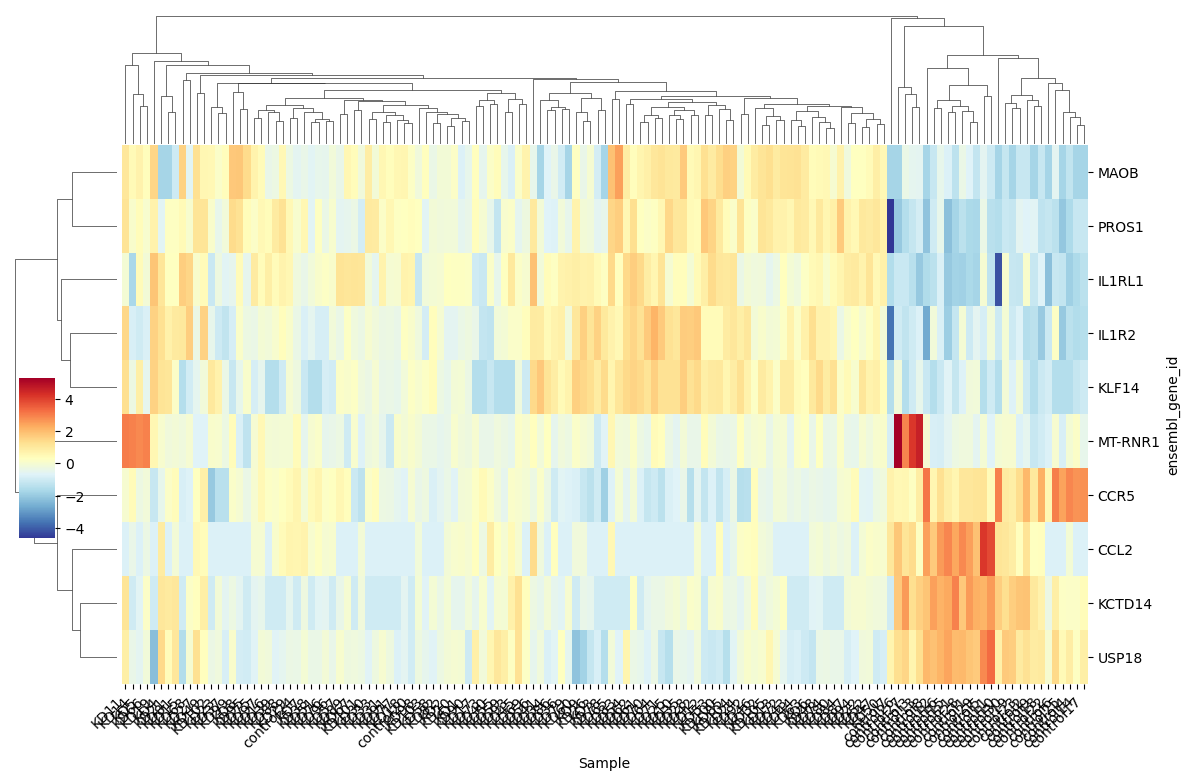


Number of genes in heatmap: 10
Number of samples in heatmap: 135


In [154]:
# First, filter the grapher dataframe to keep only genes of interest
# Convert indices to gene symbols first
grapher_genes = pd.DataFrame(
    dds_sigs.layers['log1p'].T,
    index=dds_sigs.var_names,
    columns=dds_sigs.obs_names
)
grapher_genes.index = grapher_genes.index.map(mapper.mapper)

# Filter to keep only genes of interest
grapher_filtered = grapher_genes[grapher_genes.index.isin(list_interest_genes)]

# Create clustermap
plt.figure(figsize=(12, 8))
clustermap = sns.clustermap(
    grapher_filtered,
    z_score=0,  # Standardize the data
    cmap='RdYlBu_r',  # Red-White-Blue color palette
    figsize=(12, 8),
    dendrogram_ratio=(.1, .2),  # Adjust dendrograms size
    cbar_pos=(.02, .32, .03, .2),  # Color bar position
    yticklabels=True,  # Show gene names
    xticklabels=True   # Show sample names
)

# Rotate x-axis labels for better readability
plt.setp(clustermap.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

# Add title
# plt.title('Gene Expression Heatmap of Selected Genes - '  + disease + ' disease')

# Display the plot
plt.show()

# Display clustering information
print(f"\nNumber of genes in heatmap: {len(grapher_filtered)}")
print(f"Number of samples in heatmap: {len(grapher_filtered.columns)}")

**Conclusion :**

- There are visible blocks of similarly expressed genes. 
- Sample grouping shows some separation between disease and control samples.
- The overall yellow-orange dominance suggests moderate to high expression levels across many genes.
- Some distinct patterns of differential expression are visible as contrasting color blocks.

This visualization effectively reveals gene expression patterns and sample relationships, helping identify potential disease-specific signatures and gene co-expression modules in Kawasaki Disease.

A filter can be applied to screen only the significantly expressed genes identified on the volcano plot hereinbefore.

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">5. GO Enrichment Analysis</div>

A Gene Ontology (GO) enrichment analysis is a powerful bioinformatics tool that helps biologists make sense of large gene lists by identifying biological processes, molecular functions, and cellular components that are over-represented in their data. 

This analysis is particularly valuable in disease studies as it helps researchers understand which biological processes are disrupted and potentially need therapeutic intervention.

GO terms are organized hierarchically into three main categories:
- Biological Processes (e.g., immune response, cell division)
- Molecular Functions (e.g., enzyme activity, DNA binding)
- Cellular Components (e.g., mitochondria, nucleus)
It is especially helpful because it helps scientist 

The code herebelow will : 
- Firstly download a huge "encyclopedia" (called Gene Ontology or GO) that contains information about what we know about different genes' functions - like "helps with immune response" or "involved in cell division"
- Secondly, create a map to translate between different ways of naming genes (like translating between different languages)
- Thirdly, set up a statistical tool that will look at the list of genes and check if some functions are overrepresented
- Finally, run the analysis and gives you a list of biological functions that are "enriched" in the gene list

In [155]:
# Download required files
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

# Parse GO DAG
obodag = GODag("go-basic.obo")

# Create gene ID to symbol mapper
mapper = {}
for key in GeneID2nt_human:
    mapper[GeneID2nt_human[key].Symbol] = GeneID2nt_human[key].GeneID
inv_map = {v: k for k, v in mapper.items()}

# Read NCBI's gene2go
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
ns2assoc = objanno.get_ns2assc()

# Create GO enrichment object
goeaobj = GOEnrichmentStudyNS(
    GeneID2nt_human.keys(),  # Population genes
    ns2assoc,                # Gene/GO associations
    obodag,                  # GO DAG
    propagate_counts=False,
    alpha=0.05,              # Default significance cut-off
    methods=['fdr_bh']       # Multiple testing correction
)

# Map gene symbols
mapped_genes = []
for gene in sigs['Symbol'].values:
    try:
        mapped_genes.append(mapper[gene])
    except KeyError:
        continue

print(f"Successfully mapped {len(mapped_genes)} out of {len(sigs)} genes")

# Run GO enrichment analysis
goea_results_all = goeaobj.run_study(mapped_genes)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms
HMS:0:00:54.335700 347,845 annotations, 20,780 genes, 18,718 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 81% 16,948 of 20,913 population items found in association

Load CC Ontology Enrichment Analysis ...
 86% 18,040 of 20,913 population items found in association

Load MF Ontology Enrichment Analysis ...
 84% 17,540 of 20,913 population items found in association
Successfully mapped 13232 out of 21270 genes

Runing BP Ontology Analysis: current study set of 13232 IDs.
 91% 11,993 of 13,221 study items found in association
100% 13,221 of 13,232 study items found in population(20913)
Calculating 12,143 uncorrected p-values using fisher_scipy_stats
  12,143 terms are associated with 16,948 of 20,913 population items
  11,004 terms are associated with 11,993 of 13,221 study items
  METHOD fdr_bh:
     350 GO terms found significant (< 0.05=alpha) (317 enriched +  33 pu

In [156]:
# Create results DataFrame
GO = pd.DataFrame(list(map(lambda x: [
    x.GO, 
    x.goterm.name,
    x.goterm.namespace,
    x.p_uncorrected,
    x.p_fdr_bh,
    x.ratio_in_study[0],
    x.ratio_in_study[1],
    list(map(lambda y: inv_map[y], x.study_items))
], goea_results_sig)), columns=[
    'GO', 'term', 'class', 'p', 'p_corr', 
    'n_genes', 'n_study', 'study_genes'
])


GO Enrichment Summary:
                     GO  p_corr
class                          
biological_process  344     0.0
cellular_component  223     0.0
molecular_function  154     0.0


C:\Users\Arnaud\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



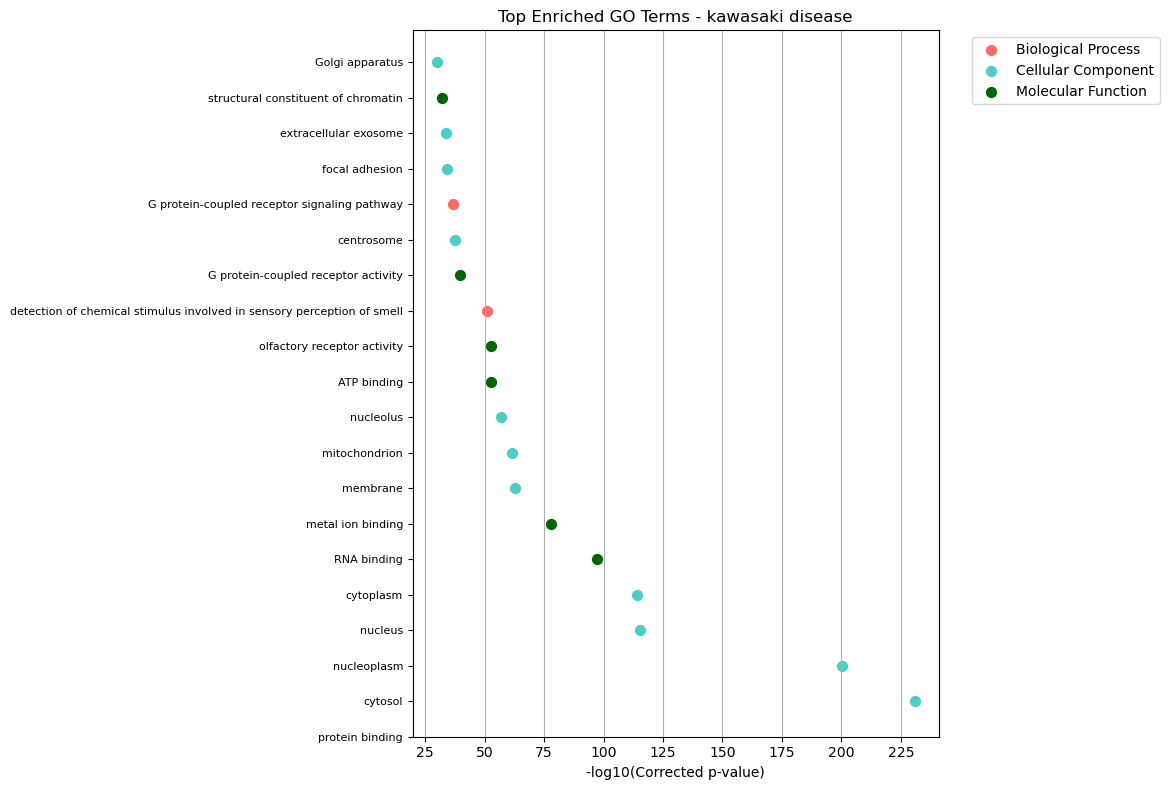

In [157]:
# Filter for minimum number of genes
GO = GO[GO.n_genes > 1]

# Create summary DataFrame
GO_summary = GO.groupby('class').agg({
    'GO': 'count',
    'p_corr': 'min'
}).round(4)
print("\nGO Enrichment Summary:")
print(GO_summary)

# Save results if directory exists
if os.path.exists('results'):
    GO.to_csv('../data/raw/go_enrichment.csv', index=False)
    
    # Save detailed results
    with open('../data/raw/go_enrichment_detailed.txt', 'w') as f:
        f.write("GO Enrichment Analysis Results\n")
        f.write("=" * 50 + "\n\n")
        
        for idx, row in GO.iterrows():
            f.write(f"GO Term: {row['GO']}\n")
            f.write(f"Name: {row['term']}\n")
            f.write(f"Class: {row['class']}\n")
            f.write(f"Corrected p-value: {row['p_corr']:.2e}\n")
            f.write(f"Genes: {', '.join(row['study_genes'])}\n")
            f.write("-" * 50 + "\n\n")

# Define colors for each GO class
class_colors = {
    'biological_process': '#FF6B6B',    # Rouge corail
    'cellular_component': '#4ECDC4',    # Turquoise
    'molecular_function': 'darkgreen'     # Bleu
}

# Visualize top GO terms
n_terms = 20
top_GO = GO.nsmallest(n_terms, 'p_corr')

# Create visualization
plt.figure(figsize=(12, 8))

# Plot points with different colors for each class
for go_class in class_colors:
    mask = top_GO['class'] == go_class
    if mask.any():
        plt.scatter(-np.log10(top_GO[mask]['p_corr']), 
                   [i for i, m in enumerate(mask) if m],
                   c=class_colors[go_class],
                   label=go_class.replace('_', ' ').title(),
                   s=50)

plt.yticks(range(n_terms), top_GO['term'], fontsize=8)
plt.xlabel('-log10(Corrected p-value)')
plt.title('Top Enriched GO Terms - ' + disease + ' disease')
plt.grid(True, axis='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\Arnaud\AppData\Local\Temp\ipykernel_1500\545689625.py:34: RuntimeWarning:

divide by zero encountered in log10



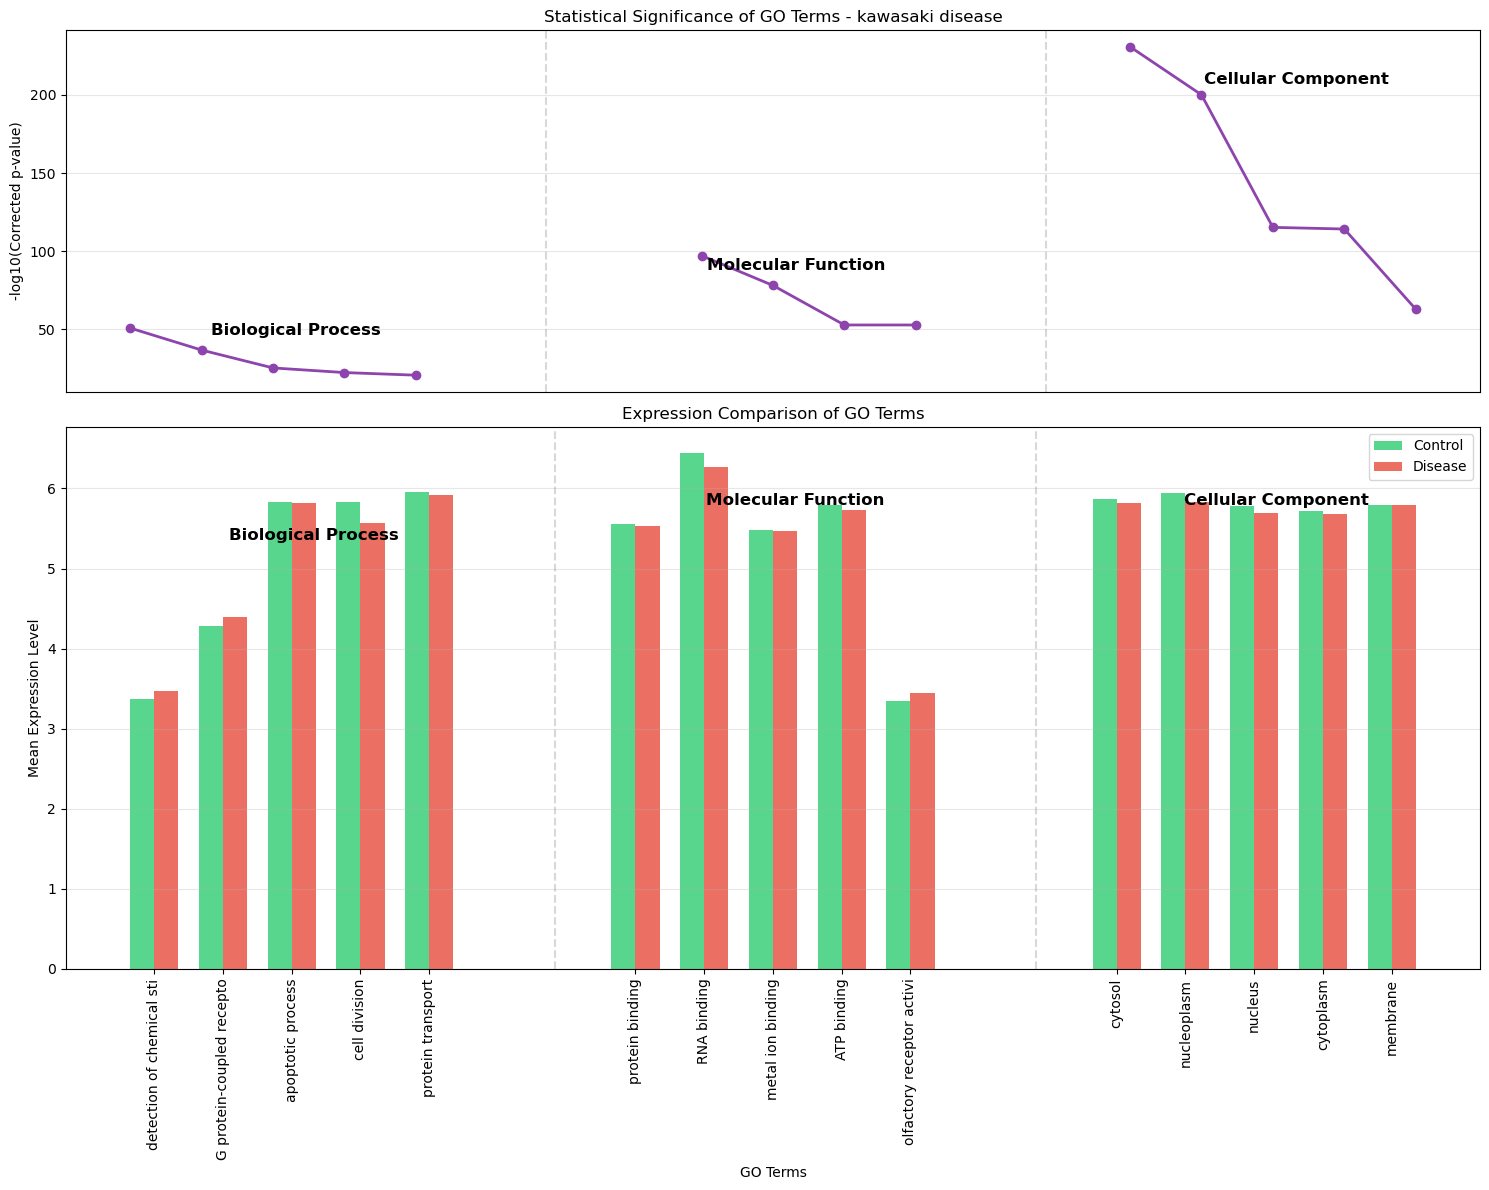


Statistical Differences:

Biological Process:
- detection of chemical sti: Fold change = 1.03 (p=1.42e-51)
- G protein-coupled recepto: Fold change = 1.03 (p=1.68e-37)
- apoptotic process: Fold change = 1.00 (p=4.53e-26)
- cell division: Fold change = 0.95 (p=4.14e-23)
- protein transport: Fold change = 0.99 (p=1.97e-21)

Molecular Function:
- protein binding: Fold change = 1.00 (p=0.00e+00)
- RNA binding: Fold change = 0.97 (p=6.54e-98)
- metal ion binding: Fold change = 1.00 (p=7.86e-79)
- ATP binding: Fold change = 0.99 (p=1.52e-53)
- olfactory receptor activi: Fold change = 1.03 (p=1.52e-53)

Cellular Component:
- cytosol: Fold change = 0.99 (p=1.69e-231)
- nucleoplasm: Fold change = 0.98 (p=8.95e-201)
- nucleus: Fold change = 0.99 (p=5.61e-116)
- cytoplasm: Fold change = 0.99 (p=6.34e-115)
- membrane: Fold change = 1.00 (p=1.17e-63)


In [158]:

# Get top 5 terms for each category
categories = ['biological_process', 'molecular_function', 'cellular_component']
n_terms_per_cat = 5

# Define disease and control columns
disease_columns = [col for col in grapher.columns if col.startswith('KD')]
control_columns = [col for col in grapher.columns if col.startswith('control')]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1.5])

# Calculate positions for bars
bar_width = 0.35
opacity = 0.8

# Process each category
current_position = 0
all_positions = []
all_labels = []
all_pvalues = []

for i, category in enumerate(categories):
    # Filter terms for this category
    cat_df = GO[GO['class'] == category].nsmallest(n_terms_per_cat, 'p_corr')
    
    if not cat_df.empty:
        # Calculate mean expression for control and diseased samples
        expression_data = []
        for _, row in cat_df.iterrows():
            genes = row['study_genes']
            disease_expr = grapher.loc[genes, disease_columns].mean().mean()
            control_expr = grapher.loc[genes, control_columns].mean().mean()
            expression_data.append((control_expr, disease_expr))
            all_pvalues.append(-np.log10(row['p_corr']))
        
        if expression_data:
            control_vals, disease_vals = zip(*expression_data)
            
            # Calculate bar positions
            index = np.arange(len(expression_data)) + current_position
            
            # Plot p-values on first subplot
            ax1.plot(index + bar_width/2, all_pvalues[-len(expression_data):], 
                    color='#8e44ad', linewidth=2, marker='o')
            
            # Plot bars on second subplot
            ax2.bar(index, control_vals, bar_width,
                   alpha=opacity, color='#2ecc71',
                   label='Control' if i == 0 else "")
            ax2.bar(index + bar_width, disease_vals, bar_width,
                   alpha=opacity, color='#e74c3c',
                   label='Disease' if i == 0 else "")
            
            # Store positions and labels
            all_positions.extend(index + bar_width/2)
            all_labels.extend([term[:25] for term in cat_df['term']])
            
            # Add category titles to both plots
            for ax in [ax1, ax2]:
                ylim = ax.get_ylim()
                ypos = ylim[1] * 0.85
                ax.text(current_position + len(expression_data)/2, 
                       ypos,
                       category.replace('_', ' ').title(),
                       ha='center', va='bottom', fontsize=12, fontweight='bold')
                
                # Centered vertical separator
                if i < len(categories) - 1:
                    separator_pos = current_position + len(expression_data) + 1
                    ax.axvline(x=separator_pos,
                             color='gray', linestyle='--', alpha=0.3)
            
            current_position += len(expression_data) + 2

# Customize first subplot (p-values)
ax1.set_ylabel('-log10(Corrected p-value)')
ax1.set_title('Statistical Significance of GO Terms - ' + disease + ' disease')
ax1.grid(True, axis='y', alpha=0.3)
ax1.set_xticks([])

# Customize second subplot (expression levels)
ax2.set_xlabel('GO Terms')
ax2.set_ylabel('Mean Expression Level')
ax2.set_title('Expression Comparison of GO Terms')
ax2.set_xticks(all_positions)
ax2.set_xticklabels(all_labels, rotation=90, fontsize=10)
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend(loc='upper right')

# Adjust layout
plt.subplots_adjust(top=0.85) 
plt.tight_layout()
plt.show()

# Print statistical information
print("\nStatistical Differences:")
print("=" * 50)
for category in categories:
    cat_df = GO[GO['class'] == category].nsmallest(n_terms_per_cat, 'p_corr')
    if not cat_df.empty:
        print(f"\n{category.replace('_', ' ').title()}:")
        for _, row in cat_df.iterrows():
            genes = row['study_genes']
            disease_expr = grapher.loc[genes, disease_columns].mean().mean()
            control_expr = grapher.loc[genes, control_columns].mean().mean()
            fold_change = disease_expr/control_expr
            print(f"- {row['term'][:25]}: Fold change = {fold_change:.2f} (p={row['p_corr']:.2e})")

# <div style="text-align: left; background-color: yellowgreen; color: white; padding: 10px; line-height:1;border-radius:10px">6. Save Results</div>

In [159]:
# Save processed data
sigs.to_csv('../data/preprocessed/sigs_' + disease + '.csv')
grapher.to_csv('../data/preprocessed/grapher_' + disease + '.csv')
GO.to_csv('../data/preprocessed/go_' + disease + '.csv')